# Example SciDB queries for trade and quote data

This iPython Notebook replicates the work done by AFL queries at [this repo's main page](https://github.com/Paradigm4/TAQ/) in SciDB-py. 

First follow the first few steps on that page to load trades and quotes data into SciDB. The last command you should run there is:
```
./quotes_redim.sh
```

Then let's run some fun queries on the loaded trades and quote (TAQ) data from the comfort of SciDB-Py.

First let us set up the connectivity to the database (and also import some useful libraries)

In [1]:
import matplotlib.pyplot as plt
from scidbpy import connect
import time
#sdb = connect() 
sdb = connect("http://10.0.20.185:8080")
afl = sdb.afl

Next, associate Python objects with SciDB arrays (no data transfers yet -- just connections)

In [2]:
trades = sdb.wrap_array('trades')
quotes = sdb.wrap_array('quotes')
tkr = sdb.wrap_array('tkr')

An example lookup

In [3]:
tkr.todataframe().head()

,symbol
symbol_index,
0,A
1,AA
2,AA PR
3,AADR
4,AAIT


## Looking up trades by symbol string

Join with the auxiliary `tkr` array to look up data by ticker symbol name. Here are examples that count the number of trades and quotes for 'BAM'.


In [4]:
symbol = "BAM"
print(sdb.merge(trades,
            tkr.filter("symbol='%s'" % symbol)
          ).nonempty())
print(sdb.merge(quotes,
            tkr.filter("symbol='%s'" % symbol)
          ).nonempty())

6337
49667


As expected we see more quotes than trades for this instrument. Note that you can also just filter directly by symbol index using `between` if you know it. For example:

In [5]:
tkr.filter("symbol='%s'" % symbol).todataframe()

,symbol
symbol_index,
615,BAM


In [7]:
print(trades.dim_names)
trades.between('null', 615, 'null', 'null', 615, 'null').nonempty()

[u'dummy', u'symbol_index', u'ms']


6337

## Computing minute bars

The trade data are now organized by symbol, time, and a dummy coordinate that separates collisions (due to, say exchanges) in a sparse array.

The following query computes and store one-minute open/high/low/close bars from these data. We need some extra aggregates from the axial_aggregate plugin: load that:

In [8]:
minute_bars = trades.apply('timeprice', 'tuple(ms,price)')
minute_bars = sdb.afl.regrid(minute_bars, 1000, 1, 60000,
            'axial_first(timeprice) as open',
            'max(price) as high',
            'min(price) as low',
            'axial_last(timeprice) as close'
          )
minute_bars = minute_bars.slice('dummy', 0)\
                            .eval()


In [9]:
minute_bars.todataframe().head()

open    high     low  close
symbol_index ms                              
0            570  61.0  63.500  60.025   62.8
             571  62.7  63.500  62.200   63.5
             572  63.6  64.899  63.000   63.6
             573  63.5  64.500  63.500   64.3
             574  64.1  64.400  64.000   64.4

Let's pull out one of these minute bar time series for a particuar stock, CVS. We can consult the symbols array to find it's index directly.

In [10]:
symbol = 'CVS'
tkr[tkr == symbol].todataframe()

,symbol
symbol_index,
1612,CVS


So this says that symbol index 1612 corresponds to CVS.

We can use SciDB's cross_join to avoid an explicit index lookup. We do need to use a repart to bring the symbols array schema into a conformable chunking scheme with the minute_bars array. Only the first 10 minutes of bars are shown below:

In [11]:
mb1 = sdb.merge(minute_bars, 
                tkr[tkr == symbol]).todataframe()
mb1.head()

open  high   low  close symbol
symbol_index ms                                 
1612         513  72.0  72.0  67.1   67.1    CVS
             560  70.1  70.1  70.1   70.1    CVS
             561  70.1  70.2  70.1   70.2    CVS
             563  70.2  70.2  70.2   70.2    CVS
             565  70.2  70.2  70.2   70.2    CVS

Note! That 570 minutes = 9:30 AM.

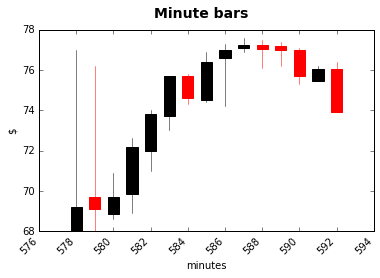

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MinuteLocator,\
    DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc

# Split the dimensions to get the minute co-ordinates
l1, l2 = zip(*mb1.index.get_values())
# unify into a nparray of tuples for use in candlestick graph
q2 = zip(l2, mb1.open, mb1.high, mb1.low, mb1.close)

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)
fig.suptitle('Minute bars', fontsize=14, fontweight='bold')
ax.set_xlabel('minutes')
ax.set_ylabel('$')

candlestick_ohlc(ax, q2[15:30], width=0.6)

ax.autoscale_view()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()